# Genre Prediction Using The Free Music Archive

The rules for how music is organized can seem arbitrary. What causes one song to fall into one category versus another may change from grader to grader. Marketers may define a genre depending on what customers wish to purchase as a group, while musicologists may decide based on rhythmic features, and untrained fans may define genre based on the bands that sound the most similar to their favorites. But what is the feature content available for machine learning approaches to define these groups autonomously? 

In this analysis we use the Free Music Archive (FMA) to attempt genre classification of three genres (Rock, Electronic, and Experimental) using categorical and quantitative features made available from Librosa and EchoNest (now Spotify). 

In [1]:
import sqlite3
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from time import time

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The FMA is organized around tracks as the central feature. Each track has information about the artist and the song represented. 

In [2]:
tracks = pd.read_csv('../data/raw/fma_metadata/tracks.csv', index_col=0, header=[0,1])
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

The FMA contains roughly 100,000 tracks across 16,000 artists.

In [3]:
print(tracks.shape)
print(len(tracks.artist.id.unique()))

(106574, 52)
16341


## EDA and Data Integrity

Before diving into the data set, we can perform some general checks on data integrity and get an idea which fields are the most incomplete, and therefore will be the most problematic for machine learning approaches.

We first take a look at columnwise completeness, assessing which columns are missing the most information.

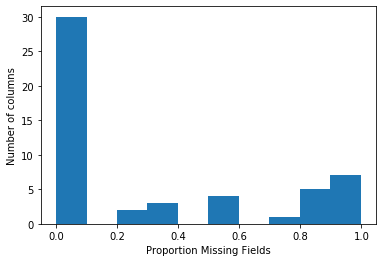

In [4]:
# Get proportion of missing fields by column
n_null = tracks.isnull().sum() / len(tracks)
plt.hist(n_null)
plt.xlabel('Proportion Missing Fields')
plt.ylabel('Number of columns')
plt.show()

We can see that there are a number of fields missing 20% or more of their data. We can inspect the dataframe to find what specific columns are represented here.

In [5]:
high_miss = n_null[n_null > 0.20]
print(high_miss)

album   date_released        0.340421
        engineer             0.856485
        information          0.219800
        producer             0.830540
artist  active_year_begin    0.786899
        active_year_end      0.949566
        associated_labels    0.866093
        bio                  0.332332
        latitude             0.582037
        location             0.341209
        longitude            0.582037
        members              0.560409
        related_projects     0.876593
        website              0.256329
        wikipedia_page       0.947633
track   composer             0.965564
        date_recorded        0.942209
        genre_top            0.534614
        information          0.977959
        language_code        0.859028
        lyricist             0.997082
        publisher            0.988149
dtype: float64


The most highly missing columns are specific string fields like `lyricist` and `publisher` or `bio`. However we do find some problematic columns that may complicate our analysis, including `genre_top`, which gives the top genre for the specified track. We can also see that roughly half of tracks are missing `longitude` and `latitude` data, which will impact geographical analysis.

We can also look at the number of unique values across each field...

In [6]:
tracks.apply(lambda x: len(pd.unique(x))).sort_values()

set     subset                   3
        split                    3
album   type                     6
track   genre_top               17
album   comments                18
track   comments                18
artist  comments                31
album   favorites               44
track   language_code           45
artist  active_year_end         58
track   lyricist                67
artist  active_year_begin       77
track   license                114
album   tracks                 115
artist  favorites              128
track   publisher              136
        favorites              243
        number                 246
artist  wikipedia_page         390
track   composer               506
album   engineer               623
artist  related_projects       753
        associated_labels      755
album   producer               761
track   date_recorded          774
artist  longitude             1297
        latitude              1307
track   information           1587
        duration    

We can observe that a small subset of rows are unique across almost all fields, a large number of rows have fewer unique values. We can see most of the same values that were missing large amounts of information here. In fact, the distribution of value counts seems mostly due to missing data. Only genre_top jumps out as a highly categorical field. We will probably want to rule out using classifiers like naive bayes which prioritize categorical data.

We also wish to investigate the row-wise missingness to assess whether the missing fields are grouped within the same track. For example, it is possible that there is a subset of 50% of tracks missing 90% of fields. This will impact our data cleaning strategy.

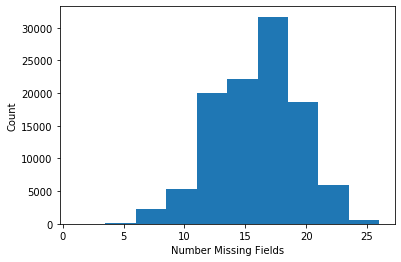

In [7]:
isna_sum = lambda row: row.isna().sum()
track_row_na = tracks.apply(isna_sum, axis=1)
plt.hist(track_row_na)
plt.xlabel('Number Missing Fields')
plt.ylabel('Count')
plt.show()

From the histogram, we can see that most tracks are missing several fields. In fact, of the 52 fields included in the dataset, a mean of roughly 17 seem to be missing for any given track. The roughly normal distribution of data tells us that there does not appear to be a single group of fields missing in a large number of tracks. We can therefore conclude that from the identified 'high missingness' tracks above, a more or less random subset of those fields can be missing for any given track.

To further verify that this is the case, we can look at broad correlation between the data, we can consider the phi coefficient (also known as the matthews coefficient), a measure of correlation between binary variables. In effect, if two fields tend to be missing at the same time, they will have a high phi coefficient. The python package `sklearn` provides an implementation of the phi coefficient.

In [8]:
# Create dataframe representation with na values flagged as True
na_grid = tracks.applymap(pd.isna)

# Create dataframe with column labels
from itertools import permutations
combos = list(permutations(tracks.columns, 2))
corr_df = pd.DataFrame(combos)

# Use column labels to coordinate application of matthews_corrcoef
from sklearn.metrics import matthews_corrcoef
corr_vals = []
for r in range(len(corr_df)):
    fields = corr_df.iloc[r]
    field1 = fields[0]
    field2 = fields[1]
    corr_val = matthews_corrcoef(na_grid[field1], na_grid[field2])
    corr_vals.append(corr_val)
corr_df['corr_val'] = corr_vals

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [9]:
corr_df.sort_values('corr_val', ascending=False)[:15]

,0,1,corr_val
1194,"(artist, longitude)","(artist, latitude)",1.000000
1093,"(artist, latitude)","(artist, longitude)",1.000000
411,"(album, producer)","(album, engineer)",0.768470
160,"(album, engineer)","(album, producer)",0.768470
613,"(album, type)","(album, date_created)",0.725658
62,"(album, date_created)","(album, type)",0.725658
1092,"(artist, latitude)","(artist, location)",0.588272
1195,"(artist, longitude)","(artist, location)",0.588272
1144,"(artist, location)","(artist, longitude)",0.588272
1143,"(artist, location)","(artist, latitude)",0.588272


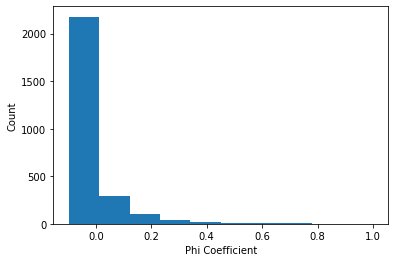

In [10]:
plt.hist(corr_df.corr_val)
plt.xlabel('Phi Coefficient')
plt.ylabel('Count')
plt.show()

From this analysis we can see a few simple trends. `latitude` and `longitude` both tend to be missing together, which makes sense, while the next most correlated missing fields are track metadata regarding production (`producer` and `engineer`) and associated album information (`type` and `date_created`). Importantly, from our histogram we don't see a great many of our classification-related fields are highly correlated.

## Genre Specification

We can inspect the genres tagged by the FMA. From the cross tables we can observe that the archive is unbalanced, with some genres having far more associated tracks than others. Here we focus on the three most abundand genres: Rock, Experimental, and Electronic.

In [11]:
genre_counts = tracks.track.genre_top.value_counts()
print(genre_counts)

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64


We can also observe that only half of the tracks have a `genre_top` designation.

In [12]:
print(tracks.shape)
print(genre_counts.sum())

(106574, 52)
49598


On closer inspection we can find that many of the tracks missing a `genre_top` value are represented in the `genres` and `genres_all` field, which links back to the `genre` table (also provided by the FMA). In future analyses, we can return to this data and attempt to identify tracks which can be considered linked to our genres investigated.

In [13]:
no_genre = tracks[tracks.track.genre_top.isna()]
no_genre.track[['genre_top', 'genres','genres_all']]

,genre_top,genres,genres_all
track_id,,,
20,NaN,"[76, 103]","[17, 10, 76, 103]"
26,NaN,"[76, 103]","[17, 10, 76, 103]"
30,NaN,"[76, 103]","[17, 10, 76, 103]"
46,NaN,"[76, 103]","[17, 10, 76, 103]"
48,NaN,"[76, 103]","[17, 10, 76, 103]"
...,...,...,...
155276,NaN,"[15, 32, 38]","[32, 38, 15]"
155277,NaN,"[15, 32, 38]","[32, 38, 15]"
155278,NaN,"[42, 107]","[42, 107, 1235, 15]"


We isolate the tracks of the genres we are interested in. This will be our focus for classification.

In [14]:
genre_tracks = tracks[tracks.track.genre_top.isin(['Rock','Experimental','Electronic'])]
print(genre_tracks.track.genre_top.value_counts())

Rock            14182
Experimental    10608
Electronic       9372
Name: genre_top, dtype: int64


## Geographic Analysis

Since we have access to location data in the FMA, it's worth asking the question of where our tracks are sourced from. Differences in region representation may lead to biases in the data, so being aware of the distribution across various areas is a good step to take.

The `geopandas` library is useful for digesting and representing geographical data. Its interoperability with `pandas` also makes it a convenient choice for analysis.

In [15]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Assign point geometry
geometry = [Point(xy) for xy in zip(tracks.artist.longitude,tracks.artist.latitude)]
crs = {'init' :'epsg:4326'}
geo_df = gpd.GeoDataFrame(tracks.copy(), crs=crs, geometry=geometry)

# We have to reduce the column labels from a multi-index for geopandas
geo_df.columns = ['_'.join(col).strip() for col in geo_df.columns.values]
geo_df.rename(columns={'geometry_':'geometry'}, inplace=True)

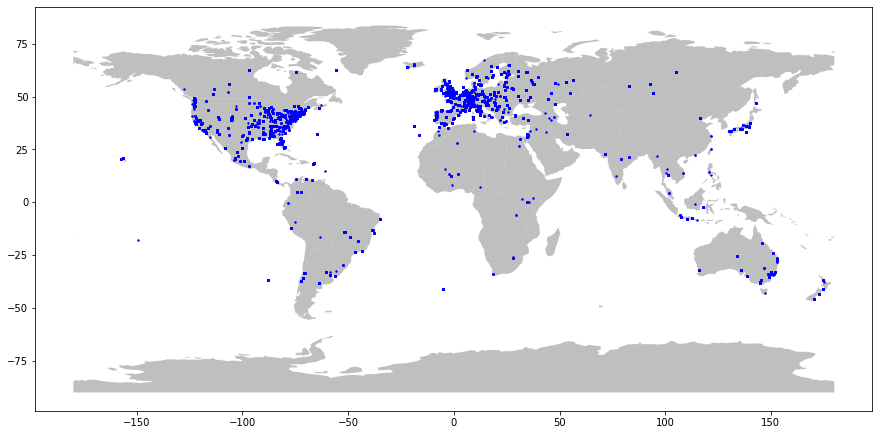

In [16]:
# We need a map to represent our data on
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize = (15,15))
world.plot(ax=ax, alpha = 0.5, color='grey')
geo_df.plot(ax=ax, markersize = 2, color = 'blue', marker='o')
plt.show()

From the map, we can see evidence that Europe and North America are much more highly represented in our dataset than other locales. We can confirm this by roughly binning continents by latitude and longitude and observing the summary table.

In [17]:
# We can merge the world map info into the tracks data
geo_tracks = gpd.sjoin(left_df=geo_df, right_df=world, how='inner')
geo_tracks.continent.value_counts()

North America    22956
Europe           15045
Oceania           1139
Asia              1065
South America      740
Africa              53
Name: continent, dtype: int64

We may also wonder whether genre differences exist between the regions, specifically in our target set of Rock, Experimental, and Electronic music. We can investigate this question as well using cross tables.

In [117]:
geo_genres = geo_tracks.loc[geo_tracks.track_genre_top.isin(['Rock','Experimental','Electronic'])]
genre_table = pd.crosstab(geo_genres.continent, geo_genres.track_genre_top)

g_table_reduced = genre_table[genre_table.index.isin(['Europe','North America'])]
g_table_reduced

track_genre_top,Electronic,Experimental,Rock
continent,,,
Europe,1884,1227,1191
North America,1249,2098,5549


In [118]:
from scipy.stats import chisquare

chisquare(g_table_reduced)

Power_divergenceResult(statistic=array([ 128.70252154,  228.16270677, 2817.82848665]), pvalue=array([7.87839653e-30, 1.49979688e-51, 0.00000000e+00]))

From this test, we can see that unsurprisingly the distribution of genres between the two continents differs significantly.

We can see that Europe has a stronger affinity with Electronic music, while North America has a strong affinity toward Rock music. Knowing these trends will be useful context as we continue our investigation. 

We can drill further down into the data by using shapefiles for specific regions. For example, if we are interested in knowing if the track data is distributed equally within states we will need a USA specific shapefile.

In [19]:
us_states = gpd.read_file('../data/raw/maps/states_21basic')

# For simplicity of plotting we skip Hawaii and Alaska
continental_us = us_states[~us_states.STATE_NAME.isin(['Alaska','Hawaii'])]
state_tracks = gpd.sjoin(left_df=geo_df.to_crs({'init': 'epsg:4269'}), right_df=continental_us, how='inner')

/usr/local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Once we have our continental US map, we need to create a column summarizing the value intensity for each region. We use the Counter object from Python's collections library to do this.

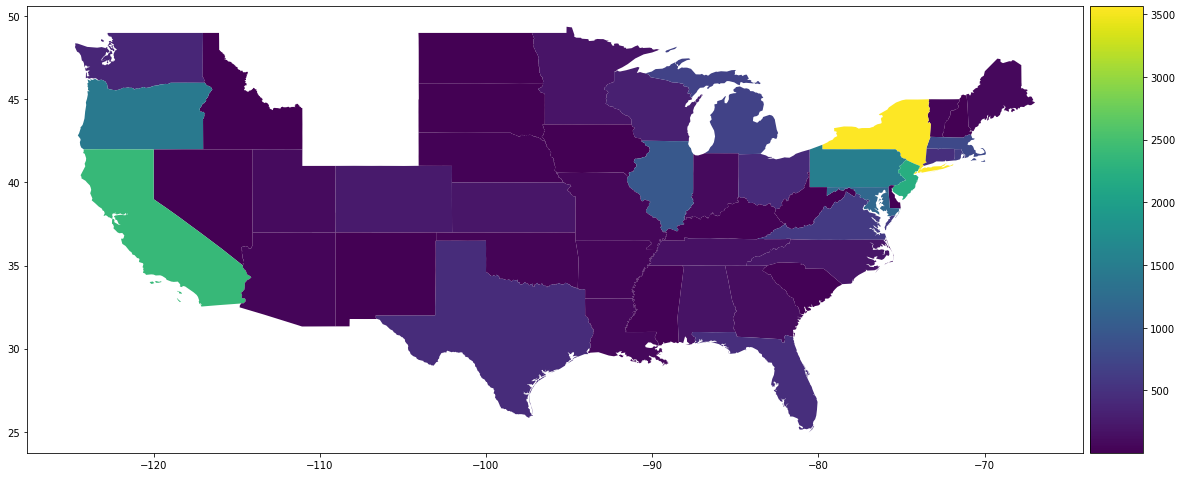

In [20]:
# We can use a Counter object to get our chloropleth values
from collections import Counter
state_count = Counter(state_tracks.STATE_NAME)
state_vals = pd.DataFrame.from_dict(state_count, orient='index').reset_index()
state_vals = state_vals.rename(columns={'index':'state', 0:'n_artists'})
us_chloropleth = continental_us.merge(state_vals, left_on='STATE_NAME', right_on='state')

# Plot chloropleth map
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
us_chloropleth.plot(column='n_artists', ax=ax, legend=True, cax=cax)
plt.show()

We can see that New York is strongly overrepresented, with California and New Jersey just behind. Midwestern, Southern, and North Atlantic states are not represented.

We can repeat the same analysis for Europe...

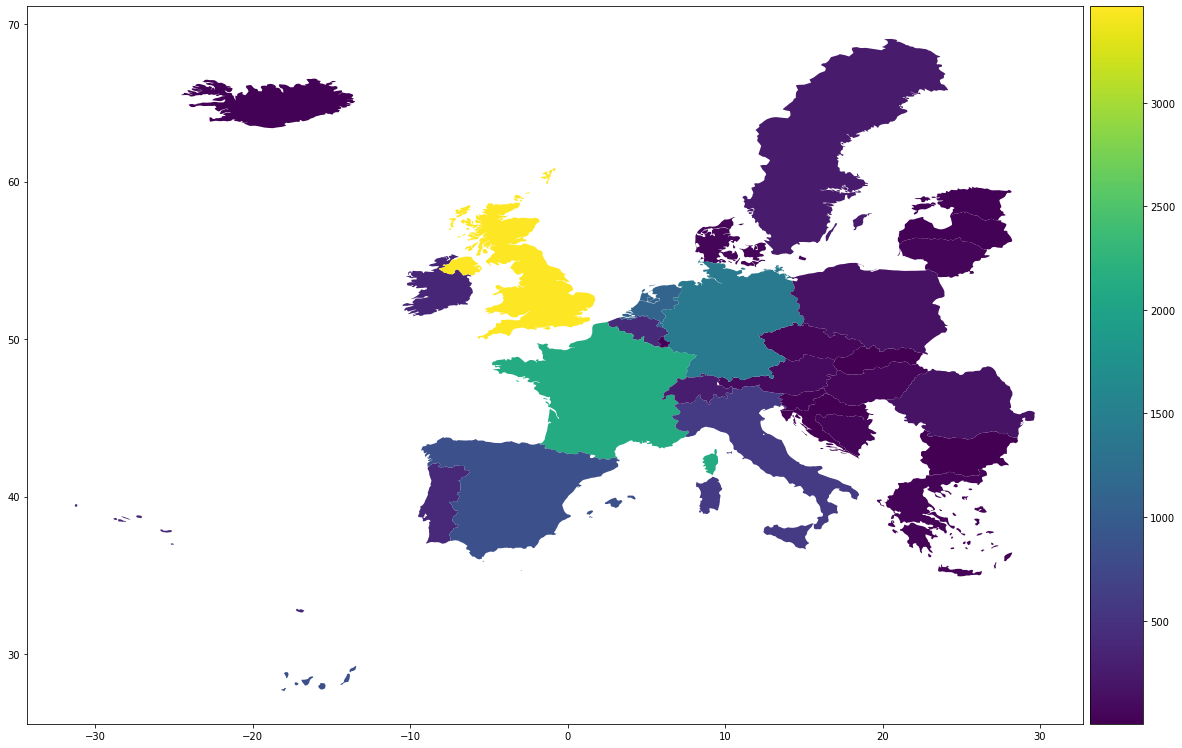

In [21]:
europe = gpd.read_file('../data/raw/maps/europe')

euro_tracks = gpd.sjoin(left_df=geo_df, right_df=europe, how='inner')
euro_count = Counter(euro_tracks.CNTRY_NAME)
euro_vals = pd.DataFrame.from_dict(euro_count, orient='index').reset_index()
euro_vals = euro_vals.rename(columns={'index':'country', 0:'n_artists'})
eu_chloropleth = europe.merge(euro_vals, left_on='CNTRY_NAME', right_on='country')

# Plot chloropleth map
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
eu_chloropleth.plot(column='n_artists', ax=ax, legend=True, cax=cax)
plt.show()

Again we can see a strong trend toward overrepresentation of one region, with Great Britain being much stronger in our dataset than other regions. France is second most well represented, with Germany trailing behind. The majority of eastern and southern Europe is less prevalent in the dataset.

We may also theorize a trend toward greater English language representation in our dataset, which we can quickly verify.

In [22]:
tracks.track.language_code.value_counts(normalize=True)[:10]

en    0.948815
es    0.013578
fr    0.012713
pt    0.005391
de    0.004526
ru    0.001997
it    0.001864
tr    0.001664
sr    0.001531
ar    0.000799
Name: language_code, dtype: float64

Indeed we see that English is by far the most popular language in the data set at 95% of all songs, with Spanish and French a distant second at roughly 13%.

## Audio Data

The FMA also provides audio features as part of its dataset. A set of Echo Nest features is included, but this only exists for roughly 10% of the archive. Due to this limitation, we will focus on the Librosa feature set, a set of summary data features for each track.

In [23]:
features = pd.read_csv('../data/raw/fma_metadata/features.csv',index_col=0,header=[0,1,2])
print(features.shape)
print(features.columns.get_level_values(0).unique())

(106574, 518)
Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')


We can see that each track has approximately 500 audio features across a broad range of feature types. These audio features are defined in [the librosa documentation.](https://librosa.github.io/librosa/feature.html) For our immediate purposes, we can think of them as general audio summary statistics.

Our next task is to merge the features file with our existing track data, filtered by genre.

## Statistical characterization of audio data

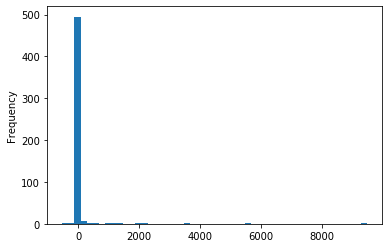

In [69]:
features.apply(np.median).plot.hist(bins=50)

We can see that the 500 audio features contain a variety of different ranges, but most of them are quite low values.

In [150]:
col = features.iloc[:,2]
print(col.min(), col.median(), col.max())

-1.9674503803 -0.16826305538500003 4.8943018913


Using our second feature as an example, we can observe that the values are spread over a wide range.

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2647., 25885., 36377., 21095.,  9519.,  4485.,  2362.,  1324.,
          793.,   541.]),
 array([-1.97966564, -1.30802038, -0.63637512,  0.03527014,  0.7069154 ,
         1.37856066,  2.05020592,  2.72185118,  3.39349644,  4.0651417 ,
         4.73678696]),
 <a list of 10 Patch objects>)

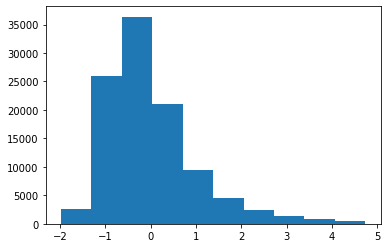

In [165]:
plt.hist(zscore(col, nan_policy='omit'))

In [78]:
from scipy.stats import zscore

outliers = np.abs(zscore(col)) > 3
print(outliers.sum(), len(outliers))

102 106574


We can see that a very small portion of these values is greater than three standard deviations of the mean. We can flag these values as outliers and impute them to a median value if necessary.

In [79]:
col.iloc[outliers]

track_id
1300        41.355400
10647       50.494202
13989       42.609516
14566      379.488800
16238       33.507576
             ...     
152094    1777.615967
152097     168.602966
153186     128.896912
154063      70.279366
154552      36.028996
Name: (chroma_cens, kurtosis, 03), Length: 102, dtype: float64

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


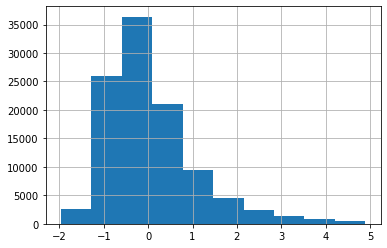

In [86]:
def impute_outliers(col, replace=np.median):
    '''Replace extreme outliers with '''
    outliers = np.abs(zscore(col)) > 3
    col.iloc[outliers] = replace(col)
    return col

impute_outliers(col).hist()

But what is the distribution of these outlier features? Are they clustered in any way or are they randomly distributed across rows and columns? We can impute them as NAN values and count to 

In [148]:
features.columns

MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '05'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ...
            (    'tonnetz',      'std', '04'),
            (    'tonnetz',      'std', '05'),
            (    'tonnetz',      'std', '06'),
            (        'zcr', 'kurtosis', '01'),
            (        'zcr',      'max', '01'),
            (        'zcr',     'mean', '01'),
            (        'zcr',   'median', '01'),
            (        'zcr',      'min', '01'),
            (        'zcr',     'skew', '01'),
            (        'zcr',      'std', '01')],
           names=['feature', 'statistics', 

In [136]:
calc_features = features.apply(impute_outliers, replace=lambda x: np.nan)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


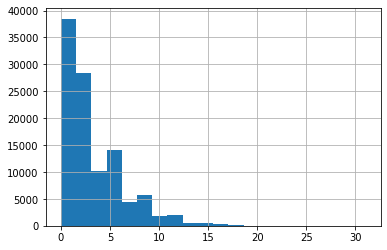

In [146]:
calc_features.isna().apply(sum, axis=1).hist(bins=20)

When we count the number of outlier features in each row (out of a possible 518) we see that most rows have a very small number of outliers, showing that we are not seeing a small population of rows contributing many outliers. This is a reassuring result, and indicates that removing these outliers or imputing them to another value will likely not have a huge effect on the data.

We can see this leads to a much more normal appearance in our data. If we wish, this function can be applied across all columns.

In [88]:
features_adjusted = features.apply(impute_outliers)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
genre_reduced = genre_tracks[[('track','genre_top')]]
feature_tracks = genre_reduced.merge(right=features, how='inner', left_index=True, right_index=True)

/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


## Modeling

For our first pass, we can consider a support vector machine (SVM), which deals well with high dimensional data.

In [25]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

svm_time = time()

training = feature_tracks.iloc[:,1:len(feature_tracks.columns)].to_numpy()
target = feature_tracks.iloc[:,0].to_numpy()

train_target, test_target, train_features, test_features = train_test_split(target, training, test_size=0.25)

svm = LinearSVC()
svm.fit(X=train_features, y=train_target)

svm_acc = svm.score(test_features, test_target)
print(svm_acc)
svm_time = time() - svm_time

0.598993092143777


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We can see that the SVM does a decent job of classifying our three target categories, though it is wrong roughly one third of the time.

We may also be curious how our classifier performs across different classes. Does it often misclassify one genre as another?

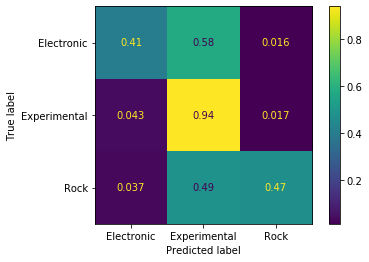

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svm, test_features, test_target, normalize='true')
plt.show()

Interestingly the classifier seems to perform well classifying the Electronic genre, but it also seems to classify everything else as electronic as well. Differentiation between Rock and Experimental seems more robust. Overall not a great result.

Let's try another model to see how it compares. We fit a neural network using the `MLPClassifier` model. We specify three hidden layers with 500 neurons each.

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

nn_time = time()

# Scale features
scaler = StandardScaler()
scaler.fit(train_features)
X_train = scaler.transform(train_features)
X_test = scaler.transform(test_features)

nnet = MLPClassifier(hidden_layer_sizes=(500,500,500), max_iter=500)
nnet.fit(X_train, train_target)

nnet_acc = nnet.score(X_test, test_target)
print('Model Accuracy:\t%.2f' % nnet_acc)
nn_time = time() - nn_time

Model Accuracy:	0.81


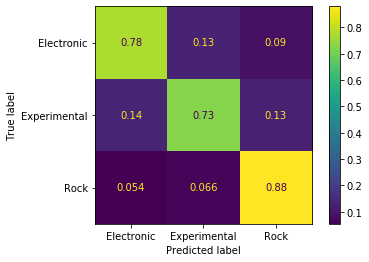

In [28]:
plot_confusion_matrix(nnet, X_test, test_target, normalize='true')
plt.show()

This result is a stark improvement over the SVM. We now achieve 80% accuracy based on the provided features. The neural network's ability to find nonlinear boundaries within the data allows it to much more effectively approximate the feature space. Ironically, the model does worse at classifying  the Electronic genre, but the improvement in the other genres more than makes up for this drop.

We now see that classification error more closely follows the representation of the genres in the data set. Rock has the most examples, while Electronic has the least. Electronic and experimental are now the most entangled.

In [29]:
# Can we improve this with listening habit information?

In [30]:
from sklearn import tree

tree_time = time()
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, train_target)
# Scores at roughly 63% accuracy
tree_acc = clf.score(X_test, test_target)
print('Model Accuracy:\t%.2f' % tree_acc)

tree_time = time() - tree_time

Model Accuracy:	0.64


In [31]:
import xgboost

xgb_time = time()

xgb = xgboost.XGBClassifier()
xgb.fit(X=X_train, y=train_target)

xgb_acc = xgb.score(X_test, test_target)
print('Model Accuracy:\t%.2f' % xgb_acc)

xgb_time = time() - xgb_time

Model Accuracy:	0.78


In [32]:
# Popularity
tracks.album.listens
tracks.album.favorites
tracks.artist.favorites
tracks.track.listens
tracks.track.favorites

tracks.album.type
tracks.album.tracks
tracks.album.tags
tracks.artist.active_year_begin
tracks.artist.active_year_end
tracks.artist.date_created
tracks.artist.location
tracks.track.bit_rate
tracks.track.date_recorded
tracks.track.interest
tracks.track.language_code
tracks.track.license

track_id
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...
10        Attribution-NonCommercial-NoDerivatives (aka M...
20        Attribution-NonCommercial-NoDerivatives (aka M...
                                ...                        
155316    Creative Commons Attribution-NonCommercial-NoD...
155317    Creative Commons Attribution-NonCommercial-NoD...
155318    Creative Commons Attribution-NonCommercial-NoD...
155319    Creative Commons Attribution-NonCommercial-NoD...
155320                            Attribution-NonCommercial
Name: license, Length: 106574, dtype: object

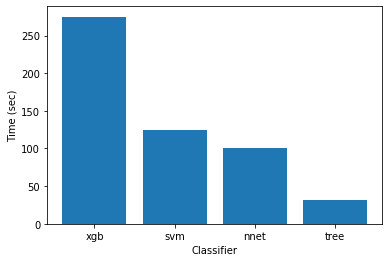

In [130]:
plt.bar(x=range(4), 
        height=[xgb_time,svm_time,nn_time,tree_time],
        tick_label=['xgb','svm','nnet','tree'])

plt.xlabel('Classifier')
plt.ylabel('Time (sec)')
plt.show()

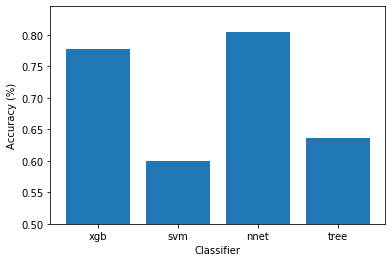

In [129]:
plt.bar(x=range(4),
       height=[xgb_acc, svm_acc, nnet_acc, tree_acc],
       tick_label=['xgb','svm','nnet','tree'])

plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')

plt.ylim(0.5)
plt.show()

The y-axis is truncated here to accuracy above 0.5 to better show the difference between the closest performing classifiers. We can see that the tree-based classifier is blazing fast compared to the other classifiers, but it is also the second least accurate. XGBoost is very accurate, but is also the slowest model to train. The SVM is both slow to train and a poorly performing classifier.

The neural network classifier appears to be the most efficient in accomplishing a good tradeoff between computational resources and model performance. 

## Model Optimization

We can now turn to the task of improving our best performing model option. One method of improving performance of a neural network method is to perform some additional feature engineering by scaling our features to be within a tighter band of values.

In [133]:
nn_time = time()

# Scale features
scaler = StandardScaler()
scaler.fit(train_features)
X_train = scaler.transform(train_features)
X_test = scaler.transform(test_features)

nnet = MLPClassifier(hidden_layer_sizes=(500,500,500), max_iter=500)
nnet.fit(X_train, train_target)

nnet_acc = nnet.score(X_test, test_target)
print('Model Accuracy:\t%.4f' % nnet_acc)
nn_time = time() - nn_time



Model Accuracy:	0.8020


In order to further improve our model, we can turn to hyperparameter tuning (the process of selecting the best set of parameters in our model for achieving the best classification results). `GridSearchCV` gives us a

In [132]:
from sklearn.model_selection import GridSearchCV

params = {#'hidden_layer_sizes': [(500,500,500), (500,500,500,500)],
          #'activation': ['tanh', 'relu'],
          #'solver': ['sgd', 'adam'],
          #'alpha': [0.0001, 0.0005, 0.001],
          #'learning_rate': ['invscaling', 'adaptive'],
          #'max_iter': [500, 1000]
         }

# grid = GridSearchCV(estimator=clf, 
#                     param_grid=params, 
#                     verbose=2)
# grid.fit(X_train, train_target)

# Model training takes a great deal of time, so we'll 
# skip to the best performing hyperparameters

clf = MLPClassifier(solver='adam', 
                    learning_rate='adaptive',
                    hidden_layer_sizes=(500,500,500),
                    alpha=0.0005,
                    activation='tanh')

clf.fit(X_train, train_target)
clf.score(X_test, test_target)


0.8006088280060882

So with that boost to training, we can get above 80% accuracy. This is a small gain, and it probably means we've come about as far as we can with the current training data given these specific modeling tools. In order to achieve better results we would have to consider more complex models that may necessitate more extreme computational resources.

In [135]:
features.shape

(106574, 518)